In [1]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import os
import pathlib
%matplotlib inline

In [2]:
CEDA_DIR = pathlib.Path("/") / "neodc"
LANDCOVER_DIR = CEDA_DIR / "esacci" / "land_cover" / "data" / "land_cover_maps" / "v2.0.7"
# Load sample data file:
landcover_2015_path = LANDCOVER_DIR / "ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif"

In [3]:
data = rasterio.open(landcover_2015_path)

In [4]:
print(data.bounds)
print(data.shape)

BoundingBox(left=-180.0, bottom=-90.00000000001438, right=180.00000000002876, top=90.0)
(64800, 129600)


In [5]:
minx, miny = 30, 50.5
maxx, maxy = 31, 52
bbox = box(minx, miny, maxx, maxy)

In [6]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [7]:
print(geo)

                                            geometry
0  POLYGON ((31.00000 50.50000, 31.00000 52.00000...


In [8]:
geo = geo.to_crs(crs=data.crs.data)

geo.crs

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Geographic 2D CRS: +init=epsg:4326 +no_defs +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
def getFeatures(gdf):
    '''Function to parse features from GeoDataFrame in such a manner that rasterio wants them'''
    import json
    return[json.loads(gdf.to_json())['features'][0]['geometry']]

In [10]:
#Get the geometry coordinates by using the function.
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[31.0, 50.5], [31.0, 52.0], [30.0, 52.0], [30.0, 50.5], [31.0, 50.5]]]}]


In [11]:
# Clip the raster with Polygon
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

In [12]:
# Copy the metadata
out_meta = data.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 129600, 'height': 64800, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.002777777777778, 0.0, -180.0,
       0.0, -0.002777777777778, 90.0)}


In [13]:
# Parse EPSG code
epsg_code = int(data.crs.data['init'][5:])
print(epsg_code)

4326


In [14]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                         )

In [15]:
out_tif = r"landcover_esacci_2015_cropped1.tif"
with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)

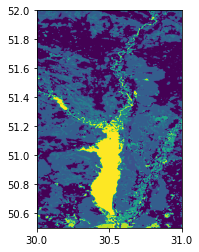

<AxesSubplot:>

In [16]:
# Open the clipped raster file
clipped = rasterio.open(out_tif)

# Visualize
show((clipped)) #Chernobyl

In [18]:
import pylandstats as pls

In [19]:
#Load output in pylandstats
ls=pls.Landscape(out_tif)  

<AxesSubplot:>

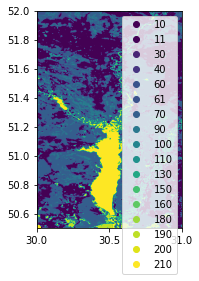

In [20]:
ls.plot_landscape(legend=True)    

In [21]:
#Calculate patch metrics using pylandstats
patch_metrics_df = ls.compute_patch_metrics_df()
patch_metrics_df.head()

,class_val,area,perimeter,perimeter_area_ratio,shape_index,fractal_dimension,euclidean_nearest_neighbor
patch_id,,,,,,,
0,10,2.314815e-09,0.022222,9.600000e+06,1.000000,0.973047,0.008333
1,10,1.543210e-09,0.016667,1.080000e+07,1.000000,0.989369,0.008333
2,10,1.543210e-09,0.016667,1.080000e+07,1.000000,0.989369,0.010015
3,10,1.543210e-09,0.016667,1.080000e+07,1.000000,0.989369,0.008784
4,10,3.564815e-07,1.161111,3.257143e+06,4.860465,0.438884,0.005556


In [22]:
#Calculate class metrics using pylandstats
class_metrics_df = ls.compute_class_metrics_df()
class_metrics_df

,total_area,proportion_of_landscape,number_of_patches,patch_density,largest_patch_index,total_edge,edge_density,landscape_shape_index,effective_mesh_size,area_mn,...,fractal_dimension_md,fractal_dimension_ra,fractal_dimension_sd,fractal_dimension_cv,euclidean_nearest_neighbor_mn,euclidean_nearest_neighbor_am,euclidean_nearest_neighbor_md,euclidean_nearest_neighbor_ra,euclidean_nearest_neighbor_sd,euclidean_nearest_neighbor_cv
class_val,,,,,,,,,,,,,,,,,,,,,
10,4.995139e-05,33.300926,698,4.653333e+08,16.328704,134.902778,899351.851852,48.410609,4.354211e-06,7.156359e-08,...,0.957030,4.670052,0.225635,24.744568,0.008370,0.005862,0.006211,0.047222,0.005190,62.005784
11,7.078704e-06,4.719136,1003,6.686667e+08,0.172325,45.516667,303444.444444,42.984375,2.979451e-09,7.057531e-09,...,0.973047,0.502692,0.073645,7.833648,0.011556,0.008242,0.007857,0.091984,0.010312,89.237330
30,3.708333e-06,2.472222,1275,8.500000e+08,0.028807,34.950000,233000.000000,45.453237,1.461683e-10,2.908497e-09,...,0.973047,0.300865,0.043864,4.588323,0.011982,0.011098,0.008784,0.085138,0.008416,70.240400
40,7.731481e-07,0.515432,432,2.880000e+08,0.006687,8.311111,55407.407407,23.437500,1.307442e-11,1.789695e-09,...,0.989369,0.176982,0.029620,3.034038,0.022241,0.022187,0.017568,0.089256,0.015864,71.325594
60,8.750000e-06,5.833333,647,4.313333e+08,0.711934,36.650000,244333.333333,31.347418,1.485103e-08,1.352396e-08,...,0.959374,0.615752,0.078846,8.401568,0.013584,0.009191,0.008333,0.108739,0.012621,92.912773
61,3.163580e-08,0.021091,15,1.000000e+07,0.003086,0.322222,2148.148148,4.461538,5.278984e-13,2.109053e-09,...,0.978043,0.058134,0.023018,2.373601,0.161615,0.142266,0.147327,0.320719,0.095403,59.031062
70,4.675849e-05,31.172325,585,3.900000e+08,6.181584,92.938889,619592.592593,34.395538,1.164865e-06,7.992904e-08,...,0.943049,1.781737,0.165007,18.280100,0.009463,0.006200,0.006211,0.042956,0.005896,62.306570
90,6.247685e-06,4.165123,736,4.906667e+08,0.411008,39.450000,263000.000000,39.677778,3.949216e-09,8.488703e-09,...,0.943049,0.808231,0.077555,8.357945,0.011890,0.008648,0.007857,0.203240,0.012602,105.987653
100,5.307099e-06,3.538066,1223,8.153333e+08,0.079733,42.363889,282425.925926,46.054217,7.361841e-10,4.339410e-09,...,0.973047,0.416200,0.058966,6.219948,0.011663,0.009293,0.008333,0.194945,0.010168,87.181509


In [23]:
#Calculate landscape metrics using pylandstats
landscape_metrics_df = ls.compute_landscape_metrics_df()
landscape_metrics_df

,total_area,number_of_patches,patch_density,largest_patch_index,total_edge,edge_density,landscape_shape_index,effective_mesh_size,area_mn,area_am,...,fractal_dimension_sd,fractal_dimension_cv,euclidean_nearest_neighbor_mn,euclidean_nearest_neighbor_am,euclidean_nearest_neighbor_md,euclidean_nearest_neighbor_ra,euclidean_nearest_neighbor_sd,euclidean_nearest_neighbor_cv,contagion,shannon_diversity_index
0,0.00015,8004,5.336000e+09,16.328704,255.375,1702500.0,53.137755,0.000006,1.874063e-08,0.000006,...,0.103597,11.027259,0.013156,0.007027,0.008333,0.692529,0.019773,150.297204,51.448827,1.850287


## Clipping the raster for Chernobyl for the 2010 and 2005 data

In [25]:
landcover_2010_path = LANDCOVER_DIR / "ESACCI-LC-L4-LCCS-Map-300m-P1Y-2010-v2.0.7.tif"
landcover_2005_path = LANDCOVER_DIR / "ESACCI-LC-L4-LCCS-Map-300m-P1Y-2005-v2.0.7.tif"

In [26]:
data2 = rasterio.open(landcover_2010_path)
data3 = rasterio.open(landcover_2005_path)

In [29]:
minx, miny = 30, 50.5
maxx, maxy = 31, 52
bbox2 = box(minx, miny, maxx, maxy)

In [30]:
# Give box a crs
geo = gpd.GeoDataFrame({'geometry': bbox2}, index=[0], crs="EPSG:4326")

In [31]:
# Make sure box crs and data crs match
geo2 = geo.to_crs(crs=data2.crs)  

geo3 = geo.to_crs(crs=data3.crs)   

In [32]:
# Co-ordinates of polygon (box)
coords2 = getFeatures(geo2)

coords3 = getFeatures(geo3)

In [33]:
# Mask(crop)
out_img2, out_transform2 = mask(dataset=data2, shapes=coords2, crop=True)    #rasterio mask

out_img3, out_transform3 = mask(dataset=data3, shapes=coords3, crop=True)    #rasterio mask

In [34]:
# Meta data for new file
out_meta2 = data2.meta.copy()
print(out_meta2)

out_meta3 = data3.meta.copy()
print(out_meta3)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 129600, 'height': 64800, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.002777777777778, 0.0, -180.0,
       0.0, -0.002777777777778, 90.0)}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 129600, 'height': 64800, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.002777777777778, 0.0, -180.0,
       0.0, -0.002777777777778, 90.0)}


In [35]:
epsg_code2 = int(data2.crs.data['init'][5:])     #putting crs into output data

epsg_code3 = int(data3.crs.data['init'][5:])     #putting crs into output data

In [36]:
# Update meta-data
out_meta2.update({"driver": "GTiff",
                 "height": out_img2.shape[1],
                 "width": out_img2.shape[2],
                 "transform": out_transform2,
                 "crs": pycrs.parse.from_epsg_code(epsg_code2).to_proj4()})

out_meta3.update({"driver": "GTiff",
                 "height": out_img3.shape[1],
                 "width": out_img3.shape[2],
                 "transform": out_transform3,
                 "crs": pycrs.parse.from_epsg_code(epsg_code3).to_proj4()})

In [37]:
# Write output file  
out_tif2 = r"landcover_esacci_2010_cropped1.tif"
with rasterio.open(out_tif2, "w+", **out_meta2) as dest:
    dest.write(out_img2)
    
out_tif3 = r"landcover_esacci_2005_cropped1.tif"
with rasterio.open(out_tif3, "w+", **out_meta3) as dest:
    dest.write(out_img3)

## Spatio-temporal analysis of CHernobyl in 2005, 2010, 2015

In [38]:
#spatio-temporal analysis
input_filepaths = [
    'landcover_esacci_2015_cropped1.tif',
    'landcover_esacci_2010_cropped1.tif',
    'landcover_esacci_2005_cropped1.tif'
]

sta = pls.SpatioTemporalAnalysis(input_filepaths, dates=[2005, 2010, 2015])

In [39]:
#Compare class metrics in 3 years
sta.compute_class_metrics_df()

metric             total_area  proportion_of_landscape  number_of_patches  \
class_val dates                                                             
10        2005   4.995139e-05                33.300926              698.0   
          2010   5.006327e-05                33.375514              690.0   
          2015   5.100926e-05                34.006173              625.0   
11        2005   7.078704e-06                 4.719136             1003.0   
          2010   7.041667e-06                 4.694444              984.0   
          2015   7.010802e-06                 4.673868              958.0   
30        2005   3.708333e-06                 2.472222             1275.0   
          2010   3.722994e-06                 2.481996             1281.0   
          2015   4.100309e-06                 2.733539             1296.0   
40        2005   7.731481e-07                 0.515432              432.0   
          2010   8.834877e-07                 0.588992              459.0   
          2015   2.266975e-06                 1.511317              646.0   
60        2005   8.750000e-06                 5.833333              647.0   
          2010   8.767747e-06                 5.845165              650.0   
          2015   7.848765e-06                 5.232510              576.0   
61        2005   3.163580e-08                 0.021091               15.0   
          2010   3.163580e-08                 0.021091               15.0   
          2015   2.854938e-08                 0.019033               13.0   
70        2005   4.675849e-05                31.172325              585.0   
          2010   4.664583e-05                31.097222              588.0   
          2015   4.593056e-05                30.620370              586.0   
90        2005   6.247685e-06                 4.165123              736.0   
          2010   6.247685e-06                 4.165123              731.0   
          2015   6.169753e-06                 4.113169              722.0   
100       2005   5.307099e-06                 3.538066             1223.0   
          2010   5.246914e-06                 3.497942             1218.0   
          2015   4.498457e-06                 2.998971             1072.0   
110       2005   5.941358e-08                 0.039609               10.0   
          2010   5.941358e-08                 0.039609               10.0   
          2015   6.018519e-08                 0.040123               10.0   
130       2005   6.267747e-06                 4.178498              588.0   
          2010   6.269290e-06                 4.179527              586.0   
          2015   6.222222e-06                 4.148148              578.0   
150       2005   4.012346e-08                 0.026749               11.0   
          2010   4.012346e-08                 0.026749               11.0   
          2015   4.012346e-08                 0.026749               11.0   
160       2005   6.087963e-07                 0.405864              243.0   
          2010   6.358025e-07                 0.423868              257.0   
          2015   4.074074e-07                 0.271605              150.0   
180       2005   7.175926e-08                 0.047840               42.0   
          2010   6.944444e-08                 0.046296               40.0   
          2015   6.712963e-08                 0.044753               34.0   
190       2005   3.255401e-06                 2.170267              322.0   
          2010   3.225309e-06                 2.150206              316.0   
          2015   3.181327e-06                 2.120885              318.0   
200       2005   3.086420e-09                 0.002058                2.0   
          2010   3.086420e-09                 0.002058                2.0   
          2015   3.086420e-09                 0.002058                2.0   
210       2005   1.108719e-05                 7.391461              172.0   
          2010   1.104630e-05                 7.364198              186.0

In [40]:
#Compare the landscape metrics in 3 years
sta.compute_landscape_metrics_df()

metric,total_area,number_of_patches,patch_density,largest_patch_index,total_edge,edge_density,landscape_shape_index,effective_mesh_size,area_mn,area_am,...,fractal_dimension_sd,fractal_dimension_cv,euclidean_nearest_neighbor_mn,euclidean_nearest_neighbor_am,euclidean_nearest_neighbor_md,euclidean_nearest_neighbor_ra,euclidean_nearest_neighbor_sd,euclidean_nearest_neighbor_cv,contagion,shannon_diversity_index
dates,,,,,,,,,,,,,,,,,,,,,
2005,0.00015,8004.0,5.336000e+09,16.328704,255.375000,1.702500e+06,53.137755,0.000006,1.874063e-08,0.000006,...,0.103597,11.027259,0.013156,0.007027,0.008333,0.692529,0.019773,150.297204,51.448827,1.850287
2010,0.00015,8024.0,5.349333e+09,16.298354,255.533333,1.703556e+06,53.170068,0.000006,1.869392e-08,0.000006,...,0.103145,10.979657,0.013145,0.007024,0.008333,0.692529,0.020292,154.373380,51.406524,1.852077
2015,0.00015,7784.0,5.189333e+09,16.670267,254.000000,1.693333e+06,52.857143,0.000006,1.927030e-08,0.000006,...,0.104453,11.137867,0.013354,0.007113,0.008333,0.692529,0.021804,163.276315,51.344139,1.858602


<AxesSubplot:ylabel='PLAND'>

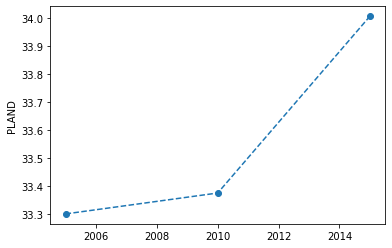

In [44]:
#the evolution of the proportion of landscape occupied by the land use class value 10
sta.plot_metric('proportion_of_landscape', class_val=10)

<AxesSubplot:ylabel='NP'>

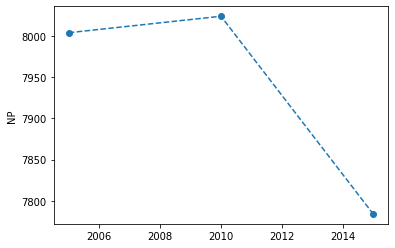

In [43]:
#the number of patches in Chernobyl from 2005 to 2015
sta.plot_metric('number_of_patches')